# Chin Yew's CNN Classification of Dangerous Object (Knives or Guns)


## Name: Chuah Chin Yew
## Company: Motorola Solutions
## Title: Solution Architect 
## Date: 20 Sep 2019





In [0]:
!pip install -qq tensorflow-gpu==2.0.0-rc1 

# ***1. Initialization***

## Download the dataset

In [0]:
rmdir knivesguns

In [3]:
!wget -qq https://www.dropbox.com/s/bgv2q2isj6fni5o/data.zip
  
!unzip -qq data.zip
!rm data.zip
!rm -r __MACOSX

!ls

data  sample_data


In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [15]:
ls

knivesguns/  test1/  train/  valid/


## Testing for GPU 


To Test if you have GPU set up

Run the Cell below

if no GPU is found press Runtime (in the menu at the top) and choose "Change Runtime Type" to GPU

In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## **Loading of Keras API**

In [0]:
mv data1 data

In [0]:

%matplotlib inline
import matplotlib.pyplot as ply

import os, json
from glob import glob

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Model,load_model,Sequential

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout,Flatten, Input
from tensorflow.keras import backend as K

import tensorflow as tf


In [0]:
mkdir guns

In [6]:
print(tf.keras.__version__)
print(tf.__version__)

2.2.4-tf
2.0.0-rc1


# ***2. Data Management***

## Converting raw files in folders into something we can feed into tf.data*

We use glob to get lists of the files in the directories and then convert them into dataframes and add in class numbers.

We also then split them up so we have 10% for a testing set and the rest for training.

finally we randomly shuffle them up


In [0]:
path = "./data/"
#path = "./data/dogscats/sample/"

In [8]:
img_width, img_height = 299, 299

path = "./data/train/"
validation_data_dir = "./data/valid/"

import glob
import pandas as pd


data = []
for root, dirs, files in os.walk(path, topdown=True):
  for name in files:
    if '.jpg' not in name:
      continue
    filename = os.path.abspath(os.path.join(root, name))
    class_name = os.path.basename(root)
    data.append((filename, class_name))
    
print(len(data))

df = pd.DataFrame(data, columns=['filename', 'class_name'])

df['class_name'] = df['class_name'].astype('category')
df['class'] = df['class_name'].cat.codes

#shuffle
df = df.sample(frac=1).reset_index(drop=True)

print(df.head())
print(len(df))
df.dtypes

517
                                            filename class_name  class
0  /content/data/train/guns/images - 2019-09-19T1...       guns      0
1  /content/data/train/guns/images - 2019-09-19T1...       guns      0
2  /content/data/train/knives/images - 2019-09-19...     knives      1
3  /content/data/train/guns/images - 2019-09-19T1...       guns      0
4  /content/data/train/knives/images - 2019-09-19...     knives      1
517


filename        object
class_name    category
class             int8
dtype: object

In [9]:
df.head(20)

,filename,class_name,class
0,/content/data/train/guns/images - 2019-09-19T1...,guns,0
1,/content/data/train/guns/images - 2019-09-19T1...,guns,0
2,/content/data/train/knives/images - 2019-09-19...,knives,1
3,/content/data/train/guns/images - 2019-09-19T1...,guns,0
4,/content/data/train/knives/images - 2019-09-19...,knives,1
5,/content/data/train/guns/images - 2019-09-19T1...,guns,0
6,/content/data/train/knives/images - 2019-09-19...,knives,1
7,/content/data/train/guns/images (100).jpg,guns,0
8,/content/data/train/guns/images (60).jpg,guns,0
9,/content/data/train/knives/images (23).jpg,knives,1


In [10]:
df.shape

(517, 3)

In [0]:

# Split into train and validation sets
train_set_percentage = .9


df = df[:int(len(df)*train_set_percentage)]
df_val = df[int(len(df)*train_set_percentage):]

# shuffle 
df = df.sample(frac=1).reset_index(drop=True)
df_val = df_val.sample(frac=1).reset_index(drop=True)

In [12]:
df_val.shape

(47, 3)

## Make the pipeline for loading and resizing the images

In [0]:
# Reads an image from a file, decodes it into a tensor, and resizes it
# to a fixed shape.
img_rows, img_cols = 299,299
num_classes = 2
batch_size = 32

def _parse_function(filename, label):
  image_string = tf.io.read_file(filename)
  image_decoded = tf.image.decode_jpeg(image_string,channels=3)
  image_resized = tf.image.resize(image_decoded, [img_rows, img_cols])
  image_resized = tf.ensure_shape(image_resized ,shape=(img_rows, img_cols,3))
  image_processed = tf.keras.applications.inception_v3.preprocess_input(image_resized) 
  label = tf.one_hot(label, num_classes)
  return image_processed, label

## Assembling the Data pipeline using tf.data

In [0]:
train_dataset = tf.data.Dataset.from_tensor_slices((tf.cast(df['filename'].values, tf.string),
                                                    tf.cast(df['class'].values, tf.int32) ))
train_dataset = train_dataset.map(_parse_function)
train_dataset = train_dataset.shuffle(5000)
train_dataset = train_dataset.repeat()
train_dataset = train_dataset.batch(batch_size, drop_remainder=True)

In [0]:
valid_dataset = tf.data.Dataset.from_tensor_slices((tf.cast(df_val['filename'].values, tf.string),
                                                    tf.cast(df_val['class'].values, tf.int32) ))
valid_dataset = valid_dataset.map(_parse_function)
valid_dataset = valid_dataset.repeat()
valid_dataset = valid_dataset.batch(batch_size, drop_remainder=True)

In [16]:
train_dataset

<BatchDataset shapes: ((32, 299, 299, 3), (32, 2)), types: (tf.float32, tf.float32)>

This will download the Inceptionv3 network weights 

In [17]:
# create the base pre-trained model
base_model = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3),pooling=None)


87916544/87910968 [==============================] - 7s 0us/step


In [18]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [0]:
# add a global spatial average pooling layer
x = base_model.output

x = GlobalAveragePooling2D()(x)

# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)

# x = Dropout(0.3)(x)

# and a logits layer -- let's say we have 2 classes
predictions = Dense(2, activation='softmax')(x)


In [0]:
# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

In [21]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    if 'batch_normalization' in layer.name:
      print(layer.name)
      layer.trainable = True
    else:
      print(layer.name)
      layer.trainable = False


input_1
conv2d
batch_normalization
activation
conv2d_1
batch_normalization_1
activation_1
conv2d_2
batch_normalization_2
activation_2
max_pooling2d
conv2d_3
batch_normalization_3
activation_3
conv2d_4
batch_normalization_4
activation_4
max_pooling2d_1
conv2d_8
batch_normalization_8
activation_8
conv2d_6
conv2d_9
batch_normalization_6
batch_normalization_9
activation_6
activation_9
average_pooling2d
conv2d_5
conv2d_7
conv2d_10
conv2d_11
batch_normalization_5
batch_normalization_7
batch_normalization_10
batch_normalization_11
activation_5
activation_7
activation_10
activation_11
mixed0
conv2d_15
batch_normalization_15
activation_15
conv2d_13
conv2d_16
batch_normalization_13
batch_normalization_16
activation_13
activation_16
average_pooling2d_1
conv2d_12
conv2d_14
conv2d_17
conv2d_18
batch_normalization_12
batch_normalization_14
batch_normalization_17
batch_normalization_18
activation_12
activation_14
activation_17
activation_18
mixed1
conv2d_22
batch_normalization_22
activation_22
conv2d

In [22]:
for layer in model.layers:
    print(layer.name,' Trainable =',layer.trainable)

input_1  Trainable = False
conv2d  Trainable = False
batch_normalization  Trainable = True
activation  Trainable = False
conv2d_1  Trainable = False
batch_normalization_1  Trainable = True
activation_1  Trainable = False
conv2d_2  Trainable = False
batch_normalization_2  Trainable = True
activation_2  Trainable = False
max_pooling2d  Trainable = False
conv2d_3  Trainable = False
batch_normalization_3  Trainable = True
activation_3  Trainable = False
conv2d_4  Trainable = False
batch_normalization_4  Trainable = True
activation_4  Trainable = False
max_pooling2d_1  Trainable = False
conv2d_8  Trainable = False
batch_normalization_8  Trainable = True
activation_8  Trainable = False
conv2d_6  Trainable = False
conv2d_9  Trainable = False
batch_normalization_6  Trainable = True
batch_normalization_9  Trainable = True
activation_6  Trainable = False
activation_9  Trainable = False
average_pooling2d  Trainable = False
conv2d_5  Trainable = False
conv2d_7  Trainable = False
conv2d_10  Trainab

In [23]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [0]:
opt = tf.keras.optimizers.Adam(lr=0.001)

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'])

In [25]:
train_steps = int(20700/32) #total trains set / batch_size
val_steps = int(2300/32)
epochs = 1

print('train steps:',train_steps)
print('val steps:',val_steps)

train steps: 646
val steps: 71


# ***3. Train the Model***

In [26]:
### Train the model with validation 
history = model.fit( train_dataset, 
                    steps_per_epoch = train_steps,
                   epochs = epochs,
                   validation_data = valid_dataset,
                   validation_steps = val_steps)

Train for 646 steps, validate for 71 steps
646/646 [==============================] - 572s 886ms/step - loss: 0.0451 - accuracy: 0.9835 - val_loss: 1.8023e-07 - val_accuracy: 1.0000


In [27]:
epochs = 4

### Train the model with validation 
history = model.fit( train_dataset, steps_per_epoch = train_steps,
                   epochs = epochs,
                   validation_data = valid_dataset,
                   validation_steps = val_steps)

Train for 646 steps, validate for 71 steps
Epoch 1/4
646/646 [==============================] - 552s 854ms/step - loss: 3.7678e-04 - accuracy: 0.9999 - val_loss: 3.3318e-08 - val_accuracy: 1.0000
Epoch 2/4
646/646 [==============================] - 554s 857ms/step - loss: 7.2975e-05 - accuracy: 1.0000 - val_loss: 1.5373e-08 - val_accuracy: 1.0000
Epoch 3/4
646/646 [==============================] - 554s 858ms/step - loss: 0.0093 - accuracy: 0.9970 - val_loss: 2.5678e-07 - val_accuracy: 1.0000
Epoch 4/4
646/646 [==============================] - 554s 857ms/step - loss: 2.8971e-05 - accuracy: 1.0000 - val_loss: 7.6605e-09 - val_accuracy: 1.0000


In [28]:
metrics = model.evaluate(valid_dataset,
                   steps = val_steps)
print("model accuracy:",metrics[1])

71/71 [==============================] - 27s 374ms/step - loss: 7.6605e-09 - accuracy: 1.0000
model accuracy: 1.0


# ***4. Prediction***

In [0]:
image_path = './data/test1/'

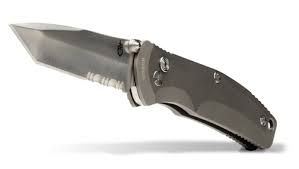

In [30]:
from IPython.display import Image

image_check = 'sample2.jpg'

Image(image_path+image_check)

In [31]:
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions
import numpy as np

img_path = os.path.join(image_path, image_check)
print(img_path)
img = image.load_img(img_path, target_size=(299, 299))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = tf.keras.applications.inception_v3.preprocess_input(x)
print('Input image shape:', x.shape)

./data/test1/sample2.jpg
Input image shape: (1, 299, 299, 3)


Using TensorFlow backend.


# ***5. Results***

In [32]:
preds = model.predict(x)
print('Predicted:', preds)

Predicted: [[3.3006197e-06 9.9999666e-01]]


In [33]:
result= preds[0][0]
if result< preds[0][1]:
    print("It's a knife")
else:
    print("It's a gun")

It's a knife


In [34]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

### Get the weights

In [0]:
# weights = model.get_weights()

In [0]:
# model.set_weights(weights)

# ***6. Fine Tuning***

In this particular case the model is already extremely accurate before fine tuning, so fine tuning doesn't help the model. 

Often for a model fine tuning can bump your accuracy by a few percent.


In [37]:

# blocks 172 or 249
for layer in model.layers[:249]:
    if 'batch_normalization' in layer.name:
      layer.trainable = True
      print(layer.name,':',layer.trainable)
    else:
      layer.trainable = False
      print(layer.name,':',layer.trainable)
for layer in model.layers[249:]:
    layer.trainable = True
    print(layer.name,':',layer.trainable)

input_1 : False
conv2d : False
batch_normalization : True
activation : False
conv2d_1 : False
batch_normalization_1 : True
activation_1 : False
conv2d_2 : False
batch_normalization_2 : True
activation_2 : False
max_pooling2d : False
conv2d_3 : False
batch_normalization_3 : True
activation_3 : False
conv2d_4 : False
batch_normalization_4 : True
activation_4 : False
max_pooling2d_1 : False
conv2d_8 : False
batch_normalization_8 : True
activation_8 : False
conv2d_6 : False
conv2d_9 : False
batch_normalization_6 : True
batch_normalization_9 : True
activation_6 : False
activation_9 : False
average_pooling2d : False
conv2d_5 : False
conv2d_7 : False
conv2d_10 : False
conv2d_11 : False
batch_normalization_5 : True
batch_normalization_7 : True
batch_normalization_10 : True
batch_normalization_11 : True
activation_5 : False
activation_7 : False
activation_10 : False
activation_11 : False
mixed0 : False
conv2d_15 : False
batch_normalization_15 : True
activation_15 : False
conv2d_13 : False
conv2

In [0]:
# model.set_weights(weights)

In [39]:
# # Train the model with validation 
history = model.fit( train_dataset, steps_per_epoch = train_steps,
                   epochs = 2,
                   validation_data = valid_dataset,
                   validation_steps = val_steps)

Train for 646 steps, validate for 71 steps
Epoch 1/2
646/646 [==============================] - 553s 856ms/step - loss: 4.4059e-04 - accuracy: 0.9999 - val_loss: 1.7630e-08 - val_accuracy: 1.0000
Epoch 2/2
646/646 [==============================] - 552s 854ms/step - loss: 5.2245e-05 - accuracy: 1.0000 - val_loss: 7.6605e-09 - val_accuracy: 1.0000


In [0]:
metrics = model.evaluate(valid_dataset,
                   steps = val_steps)
print("model accuracy:",metrics[1])

71/71 [==============================] - 14s 204ms/step - loss: 8.9407e-08 - accuracy: 1.0000
model accuracy: 1.0
